### LASSO parameter range experiments, summary across all genes

In [1]:
import os
import itertools as it

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import seaborn as sns

import pancancer_evaluation.config as cfg
import pancancer_evaluation.utilities.data_utilities as du
import pancancer_evaluation.utilities.analysis_utilities as au

%load_ext autoreload
%autoreload 2

In [2]:
ll_results_dir = os.path.join(
    cfg.repo_root, '01_stratified_classification', 'results', 'optimizer_compare_ll', 'gene'
)

sgd_results_dir = os.path.join(
    cfg.repo_root, '01_stratified_classification', 'results', 'optimizer_compare_sgd', 'gene'
)

plot_gene = 'EGFR'
metric = 'aupr'

### Get coefficient information for each lasso penalty

In [3]:
ll_nz_coefs_df = []

# get coefficient info for training dataset specified above
for coef_info in au.generate_nonzero_coefficients_lasso_range(ll_results_dir):
    (gene,
     cancer_type,
     seed,
     lasso_param,
     coefs_list) = coef_info
    for fold_no, coefs in enumerate(coefs_list):
        ll_nz_coefs_df.append(
            [gene, cancer_type, lasso_param, seed, fold_no, len(coefs)]
        )
        
ll_nz_coefs_df = pd.DataFrame(
    ll_nz_coefs_df,
    columns=['gene', 'signal', 'lasso_param', 'seed', 'fold', 'nz_coefs']
)
ll_nz_coefs_df.lasso_param = ll_nz_coefs_df.lasso_param.astype(float)

print(ll_nz_coefs_df.gene.unique())
ll_nz_coefs_df.head()

['MAP3K1' 'TP53' 'KDM5C' 'RB1' 'CIC' 'BRAF' 'JAK1' 'ARID2' 'CSF1R' 'JAK3'
 'NPM1' 'H3F3A' 'GNA11' 'PBRM1' 'MAP2K1' 'MET' 'CDKN2A' 'NCOR1' 'FLT3'
 'CREBBP' 'ALK' 'SMARCA4' 'FOXL2' 'NF2' 'BCOR' 'NRAS' 'ERBB2' 'ARID1A'
 'PDGFRA' 'AXIN1' 'MED12' 'SETBP1' 'KDM6A' 'STK11' 'NOTCH1' 'TSC1' 'STAG2'
 'SMAD4' 'ARID1B' 'FGFR2' 'FBXW7' 'EGFR' 'APC' 'IDH2' 'VHL' 'IDH1' 'EP300'
 'GATA3' 'ATRX' 'HRAS' 'GNAS' 'SMAD2' 'CTNNB1' 'PTEN' 'DNMT1' 'ABL1'
 'PIK3CA' 'NOTCH2' 'FGFR3' 'GATA2' 'CARD11' 'KIT' 'ATM' 'ASXL1' 'CDH1'
 'BAP1' 'FUBP1' 'SF3B1' 'RNF43' 'NF1' 'PRDM1' 'NFE2L2' 'BRCA2' 'PIK3R1'
 'SETD2' 'CASP8' 'SPOP' 'SOX9' 'GNAQ' 'PPP2R1A' 'KRAS' 'JAK2' 'EZH2'
 'HIST1H3B']


,gene,signal,lasso_param,seed,fold,nz_coefs
0,MAP3K1,signal,1000.0,1,0,5942
1,MAP3K1,signal,1000.0,1,1,5369
2,MAP3K1,signal,1000.0,1,2,5626
3,MAP3K1,signal,1000.0,1,3,5351
4,MAP3K1,signal,100.0,1,0,2622


In [4]:
sgd_nz_coefs_df = []

# get coefficient info for training dataset specified above
for coef_info in au.generate_nonzero_coefficients_lasso_range(sgd_results_dir):
    (gene,
     cancer_type,
     seed,
     lasso_param,
     coefs_list) = coef_info
    for fold_no, coefs in enumerate(coefs_list):
        sgd_nz_coefs_df.append(
            [gene, cancer_type, lasso_param, seed, fold_no, len(coefs)]
        )
        
sgd_nz_coefs_df = pd.DataFrame(
    sgd_nz_coefs_df,
    columns=['gene', 'signal', 'lasso_param', 'seed', 'fold', 'nz_coefs']
)
sgd_nz_coefs_df.lasso_param = sgd_nz_coefs_df.lasso_param.astype(float)

print(sgd_nz_coefs_df.gene.unique())
sgd_nz_coefs_df.head()

['MAP3K1' 'TP53' 'KDM5C' 'RB1' 'CIC' 'BRAF' 'JAK1' 'ARID2' 'CSF1R' 'JAK3'
 'NPM1' 'H3F3A' 'GNA11' 'PBRM1' 'MAP2K1' 'MET' 'CDKN2A' 'NCOR1' 'FLT3'
 'CREBBP' 'ALK' 'SMARCA4' 'FOXL2' 'NF2' 'BCOR' 'NRAS' 'ERBB2' 'ARID1A'
 'PDGFRA' 'AXIN1' 'MED12' 'SETBP1' 'KDM6A' 'STK11' 'NOTCH1' 'TSC1' 'STAG2'
 'SMAD4' 'ARID1B' 'FGFR2' 'FBXW7' 'EGFR' 'APC' 'IDH2' 'VHL' 'IDH1' 'EP300'
 'GATA3' 'ATRX' 'HRAS' 'GNAS' 'SMAD2' 'CTNNB1' 'PTEN' 'DNMT1' 'ABL1'
 'PIK3CA' 'NOTCH2' 'FGFR3' 'GATA2' 'CARD11' 'KIT' 'ATM' 'ASXL1' 'CDH1'
 'BAP1' 'FUBP1' 'SF3B1' 'RNF43' 'NF1' 'PRDM1' 'NFE2L2' 'BRCA2' 'PIK3R1'
 'SETD2' 'CASP8' 'SPOP' 'SOX9' 'GNAQ' 'PPP2R1A' 'KRAS' 'JAK2' 'EZH2'
 'HIST1H3B']


,gene,signal,lasso_param,seed,fold,nz_coefs
0,MAP3K1,signal,0.00005,42,0,15206
1,MAP3K1,signal,0.00005,42,1,15209
2,MAP3K1,signal,0.00005,42,2,15203
3,MAP3K1,signal,0.00005,42,3,15208
4,MAP3K1,signal,10.00000,1,0,0


### Get performance information for each lasso penalty

In [5]:
ll_perf_df = au.load_prediction_results_lasso_range(ll_results_dir,
                                                    'stratified')
ll_perf_df = (ll_perf_df
    .drop(columns=['holdout_cancer_type', 'experiment'])
    .copy()
)
ll_perf_df.lasso_param = ll_perf_df.lasso_param.astype(float)

print(ll_perf_df.shape)
print(ll_perf_df.gene.unique())
ll_perf_df.head()

(32256, 8)
['MAP3K1' 'TP53' 'KDM5C' 'RB1' 'CIC' 'BRAF' 'JAK1' 'ARID2' 'CSF1R' 'JAK3'
 'NPM1' 'H3F3A' 'GNA11' 'PBRM1' 'MAP2K1' 'MET' 'CDKN2A' 'NCOR1' 'FLT3'
 'CREBBP' 'ALK' 'SMARCA4' 'FOXL2' 'NF2' 'BCOR' 'NRAS' 'ERBB2' 'ARID1A'
 'PDGFRA' 'AXIN1' 'MED12' 'SETBP1' 'KDM6A' 'STK11' 'NOTCH1' 'TSC1' 'STAG2'
 'SMAD4' 'ARID1B' 'FGFR2' 'FBXW7' 'EGFR' 'APC' 'IDH2' 'VHL' 'IDH1' 'EP300'
 'GATA3' 'ATRX' 'HRAS' 'GNAS' 'SMAD2' 'CTNNB1' 'PTEN' 'DNMT1' 'ABL1'
 'PIK3CA' 'NOTCH2' 'FGFR3' 'GATA2' 'CARD11' 'KIT' 'ATM' 'ASXL1' 'CDH1'
 'BAP1' 'FUBP1' 'SF3B1' 'RNF43' 'NF1' 'PRDM1' 'NFE2L2' 'BRCA2' 'PIK3R1'
 'SETD2' 'CASP8' 'SPOP' 'SOX9' 'GNAQ' 'PPP2R1A' 'KRAS' 'JAK2' 'EZH2'
 'HIST1H3B']


,auroc,aupr,gene,signal,seed,data_type,fold,lasso_param
0,0.73614,0.38387,MAP3K1,signal,1,train,0,0.01
1,0.60446,0.26584,MAP3K1,signal,1,test,0,0.01
2,0.63282,0.32077,MAP3K1,signal,1,cv,0,0.01
3,0.66756,0.32635,MAP3K1,signal,1,train,1,0.01
4,0.70488,0.28401,MAP3K1,signal,1,test,1,0.01


In [6]:
sgd_perf_df = au.load_prediction_results_lasso_range(sgd_results_dir,
                                                    'stratified')
sgd_perf_df = (sgd_perf_df
    .drop(columns=['holdout_cancer_type', 'experiment'])
    .copy()
)
sgd_perf_df.lasso_param = sgd_perf_df.lasso_param.astype(float)

print(sgd_perf_df.shape)
print(sgd_perf_df.gene.unique())
sgd_perf_df.head()

(30240, 8)
['MAP3K1' 'TP53' 'KDM5C' 'RB1' 'CIC' 'BRAF' 'JAK1' 'ARID2' 'CSF1R' 'JAK3'
 'NPM1' 'H3F3A' 'GNA11' 'PBRM1' 'MAP2K1' 'MET' 'CDKN2A' 'NCOR1' 'FLT3'
 'CREBBP' 'ALK' 'SMARCA4' 'FOXL2' 'NF2' 'BCOR' 'NRAS' 'ERBB2' 'ARID1A'
 'PDGFRA' 'AXIN1' 'MED12' 'SETBP1' 'KDM6A' 'STK11' 'NOTCH1' 'TSC1' 'STAG2'
 'SMAD4' 'ARID1B' 'FGFR2' 'FBXW7' 'EGFR' 'APC' 'IDH2' 'VHL' 'IDH1' 'EP300'
 'GATA3' 'ATRX' 'HRAS' 'GNAS' 'SMAD2' 'CTNNB1' 'PTEN' 'DNMT1' 'ABL1'
 'PIK3CA' 'NOTCH2' 'FGFR3' 'GATA2' 'CARD11' 'KIT' 'ATM' 'ASXL1' 'CDH1'
 'BAP1' 'FUBP1' 'SF3B1' 'RNF43' 'NF1' 'PRDM1' 'NFE2L2' 'BRCA2' 'PIK3R1'
 'SETD2' 'CASP8' 'SPOP' 'SOX9' 'GNAQ' 'PPP2R1A' 'KRAS' 'JAK2' 'EZH2'
 'HIST1H3B']


,auroc,aupr,gene,signal,seed,data_type,fold,lasso_param
0,0.95763,0.67117,MAP3K1,signal,1,train,0,0.01
1,0.53301,0.13583,MAP3K1,signal,1,test,0,0.01
2,0.61076,0.17604,MAP3K1,signal,1,cv,0,0.01
3,0.95056,0.60774,MAP3K1,signal,1,train,1,0.01
4,0.67100,0.16087,MAP3K1,signal,1,test,1,0.01


### Get "best" LASSO parameter and compare performance across all genes

Here, we'll just define the "best" model as the one with the highest validation set AUPR. We'll do this for each gene in the Vogelstein dataset, separately for each optimizer, and plot the distribution of AUPR differences between the two optimizers to give an idea of which one tends to be "better".

In [7]:
ll_top_df = []

# get top-performing lasso param for each gene,
# based on mean performance across seeds/folds
for gene in ll_perf_df.gene.unique():
    ll_mean_perf_df = (
      ll_perf_df[(ll_perf_df.gene == gene) &
                 (ll_perf_df.data_type == 'cv') &
                 (ll_perf_df.signal == 'signal')]
          .groupby(['lasso_param'])
          .agg(np.mean)
          .drop(columns=['seed', 'fold'])
          .rename(columns={'auroc': 'mean_auroc', 'aupr': 'mean_aupr'})
          .sort_values(by='mean_aupr', ascending=False)
          .reset_index()
    )
    ll_mean_perf_df['gene'] = gene
    ll_top_df.append(ll_mean_perf_df.iloc[[0], :])
    
ll_top_df = (
    pd.concat(ll_top_df)
      .set_index('gene')
)
print(ll_top_df.shape)
ll_top_df.head()

(84, 3)


,lasso_param,mean_auroc,mean_aupr
gene,,,
MAP3K1,5.00,0.679876,0.297611
TP53,0.05,0.927659,0.899840
KDM5C,5.00,0.885964,0.459093
RB1,0.05,0.857610,0.465474
CIC,0.05,0.879469,0.760219


In [8]:
sgd_top_df = []

# get top-performing lasso param for each gene,
# based on mean performance across seeds/folds
for gene in sgd_perf_df.gene.unique():
    sgd_mean_perf_df = (
      sgd_perf_df[(sgd_perf_df.gene == gene) &
                  (sgd_perf_df.data_type == 'cv') &
                  (sgd_perf_df.signal == 'signal')]
          .groupby(['lasso_param'])
          .agg(np.mean)
          .drop(columns=['seed', 'fold'])
          .rename(columns={'auroc': 'mean_auroc', 'aupr': 'mean_aupr'})
          .sort_values(by='mean_aupr', ascending=False)
          .reset_index()
    )
    sgd_mean_perf_df['gene'] = gene
    sgd_top_df.append(sgd_mean_perf_df.iloc[[0], :])
    
sgd_top_df = (
    pd.concat(sgd_top_df)
      .set_index('gene')
)
print(sgd_top_df.shape)
sgd_top_df.head()

(84, 3)


,lasso_param,mean_auroc,mean_aupr
gene,,,
MAP3K1,0.001000,0.618923,0.190456
TP53,0.000001,0.905170,0.880779
KDM5C,0.100000,0.787602,0.268776
RB1,0.000005,0.794930,0.369872
CIC,0.010000,0.827439,0.523364


In [9]:
def get_top_optimizer_diff(gene):
    # TODO: put some of repeated code in functions
    ll_top_lasso_param = ll_top_df.loc[gene, 'lasso_param']
    sgd_top_lasso_param = sgd_top_df.loc[gene, 'lasso_param']
    
    ll_mean_test_perf_df = (
        ll_perf_df[(ll_perf_df.gene == gene) &
                   (ll_perf_df.data_type == 'test') &
                   (ll_perf_df.signal == 'signal')]
          .groupby(['lasso_param'])
          .agg(np.mean)
          .drop(columns=['seed', 'fold'])
          .rename(columns={'auroc': 'mean_auroc', 'aupr': 'mean_aupr'})
    )
    sgd_mean_test_perf_df = (
        sgd_perf_df[(sgd_perf_df.gene == gene) &
                    (sgd_perf_df.data_type == 'test') &
                    (sgd_perf_df.signal == 'signal')]
          .groupby(['lasso_param'])
          .agg(np.mean)
          .drop(columns=['seed', 'fold'])
          .rename(columns={'auroc': 'mean_auroc', 'aupr': 'mean_aupr'})
    )
    ll_sgd_diff = (
        ll_mean_test_perf_df.loc[ll_top_lasso_param, 'mean_aupr'] -
        sgd_mean_test_perf_df.loc[sgd_top_lasso_param, 'mean_aupr']
    )
    
    return [gene,
            ll_top_lasso_param,
            sgd_top_lasso_param,
            ll_sgd_diff]

print(get_top_optimizer_diff('PTEN'))

['PTEN', 0.05, 1e-06, 0.10895999999999995]


In [10]:
all_top_optimizer_diff_df = []

for gene in ll_perf_df.gene.unique():
    all_top_optimizer_diff_df.append(
        get_top_optimizer_diff(gene)
    )
        
all_top_optimizer_diff_df = pd.DataFrame(
    all_top_optimizer_diff_df,
    columns=['gene', 'll_top_lasso_param',
             'sgd_top_lasso_param', 'll_sgd_diff']
)

all_top_optimizer_diff_df['best'] = 'liblinear'
all_top_optimizer_diff_df.loc[
    all_top_optimizer_diff_df.ll_sgd_diff < 0, 'best'
] = 'sgd'
# this probably won't happen but just in case
all_top_optimizer_diff_df.loc[
    all_top_optimizer_diff_df.ll_sgd_diff == 0, 'best'
] = 'equal'

print(all_top_optimizer_diff_df.best.value_counts())
all_top_optimizer_diff_df.head()

liblinear    71
sgd          13
Name: best, dtype: int64


,gene,ll_top_lasso_param,sgd_top_lasso_param,ll_sgd_diff,best
0,MAP3K1,5.00,0.001000,0.183724,liblinear
1,TP53,0.05,0.000001,0.022298,liblinear
2,KDM5C,5.00,0.100000,0.217613,liblinear
3,RB1,0.05,0.000005,0.110349,liblinear
4,CIC,0.05,0.010000,0.179511,liblinear


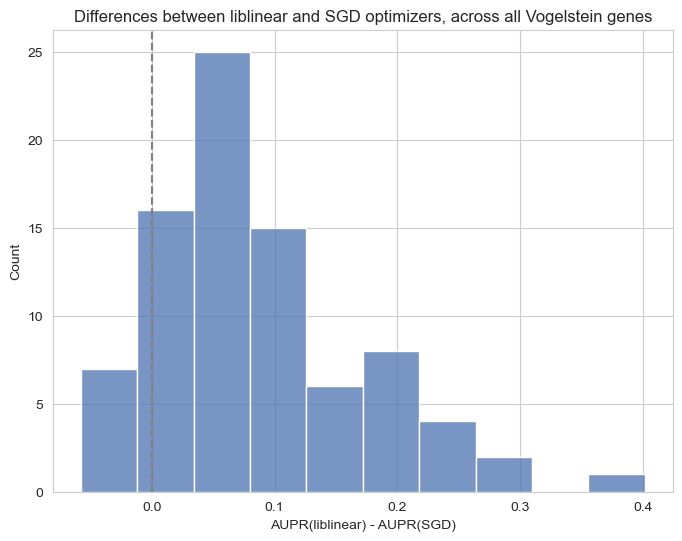

In [11]:
sns.set({'figure.figsize': (8, 6)})
sns.set_style('whitegrid')

sns.histplot(all_top_optimizer_diff_df.ll_sgd_diff)
plt.title('Differences between liblinear and SGD optimizers, across all Vogelstein genes')
plt.xlabel('AUPR(liblinear) - AUPR(SGD)')
plt.gca().axvline(0, color='grey', linestyle='--')

In [12]:
all_top_optimizer_diff_df.sort_values(by='ll_sgd_diff', ascending=False).head(10)

,gene,ll_top_lasso_param,sgd_top_lasso_param,ll_sgd_diff,best
66,FUBP1,10.00,0.100000,0.401069,liblinear
64,CDH1,0.05,0.100000,0.294805,liblinear
75,CASP8,10.00,0.050000,0.268601,liblinear
36,STAG2,0.05,0.000001,0.246041,liblinear
76,SPOP,10.00,0.000001,0.223699,liblinear
41,EGFR,0.01,0.000005,0.223641,liblinear
71,NFE2L2,0.05,0.000005,0.220278,liblinear
2,KDM5C,5.00,0.100000,0.217613,liblinear
37,SMAD4,0.05,0.000001,0.211696,liblinear
48,ATRX,0.05,0.005000,0.193821,liblinear


In [13]:
all_top_optimizer_diff_df.sort_values(by='ll_sgd_diff', ascending=True).head(10)

,gene,ll_top_lasso_param,sgd_top_lasso_param,ll_sgd_diff,best
10,NPM1,50.00,0.000500,-0.057480,sgd
8,CSF1R,50.00,0.000500,-0.055601,sgd
83,HIST1H3B,50.00,0.005000,-0.026711,sgd
82,EZH2,500.00,0.000100,-0.022414,sgd
44,VHL,5.00,0.000010,-0.020694,sgd
19,CREBBP,0.05,0.000010,-0.016869,sgd
30,MED12,5.00,0.000010,-0.016041,sgd
55,ABL1,100.00,0.000010,-0.010077,sgd
62,ATM,0.01,0.000001,-0.008480,sgd
38,ARID1B,50000.00,0.050000,-0.006491,sgd


### Compare feature selection with performance

In [14]:
ll_coefs_perf_df = (ll_top_df
    .reset_index()
    .merge(ll_nz_coefs_df,
           on=['gene', 'lasso_param'])
    .drop(columns=['signal'])
)
ll_coefs_perf_df['optimizer'] = 'liblinear'

print(ll_coefs_perf_df.shape)
ll_coefs_perf_df.head()

(672, 8)


,gene,lasso_param,mean_auroc,mean_aupr,seed,fold,nz_coefs,optimizer
0,MAP3K1,5.0,0.679876,0.297611,42,0,542,liblinear
1,MAP3K1,5.0,0.679876,0.297611,42,1,800,liblinear
2,MAP3K1,5.0,0.679876,0.297611,42,2,607,liblinear
3,MAP3K1,5.0,0.679876,0.297611,42,3,841,liblinear
4,MAP3K1,5.0,0.679876,0.297611,1,0,799,liblinear


In [15]:
sgd_coefs_perf_df = (sgd_top_df
    .reset_index()
    .merge(sgd_nz_coefs_df,
           on=['gene', 'lasso_param'])
    .drop(columns=['signal'])
)
sgd_coefs_perf_df['optimizer'] = 'sgd'

print(sgd_coefs_perf_df.shape)
sgd_coefs_perf_df.head()

(672, 8)


,gene,lasso_param,mean_auroc,mean_aupr,seed,fold,nz_coefs,optimizer
0,MAP3K1,0.001,0.618923,0.190456,42,0,13468,sgd
1,MAP3K1,0.001,0.618923,0.190456,42,1,13410,sgd
2,MAP3K1,0.001,0.618923,0.190456,42,2,13299,sgd
3,MAP3K1,0.001,0.618923,0.190456,42,3,13015,sgd
4,MAP3K1,0.001,0.618923,0.190456,1,0,13368,sgd


Text(0, 0.5, 'Number of nonzero coefficients')

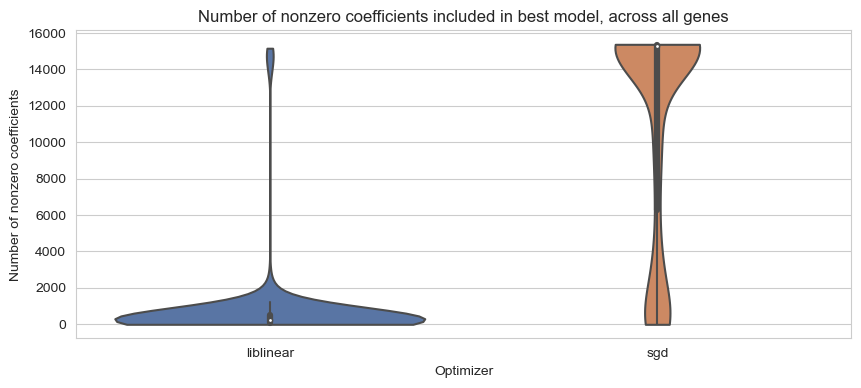

In [16]:
sns.set({'figure.figsize': (10, 4)})
sns.set_style('whitegrid')

coefs_perf_df = pd.concat((ll_coefs_perf_df, sgd_coefs_perf_df))
sns.violinplot(data=coefs_perf_df, x='optimizer', y='nz_coefs', cut=0)
plt.title('Number of nonzero coefficients included in best model, across all genes')
plt.xlabel('Optimizer')
plt.ylabel('Number of nonzero coefficients')

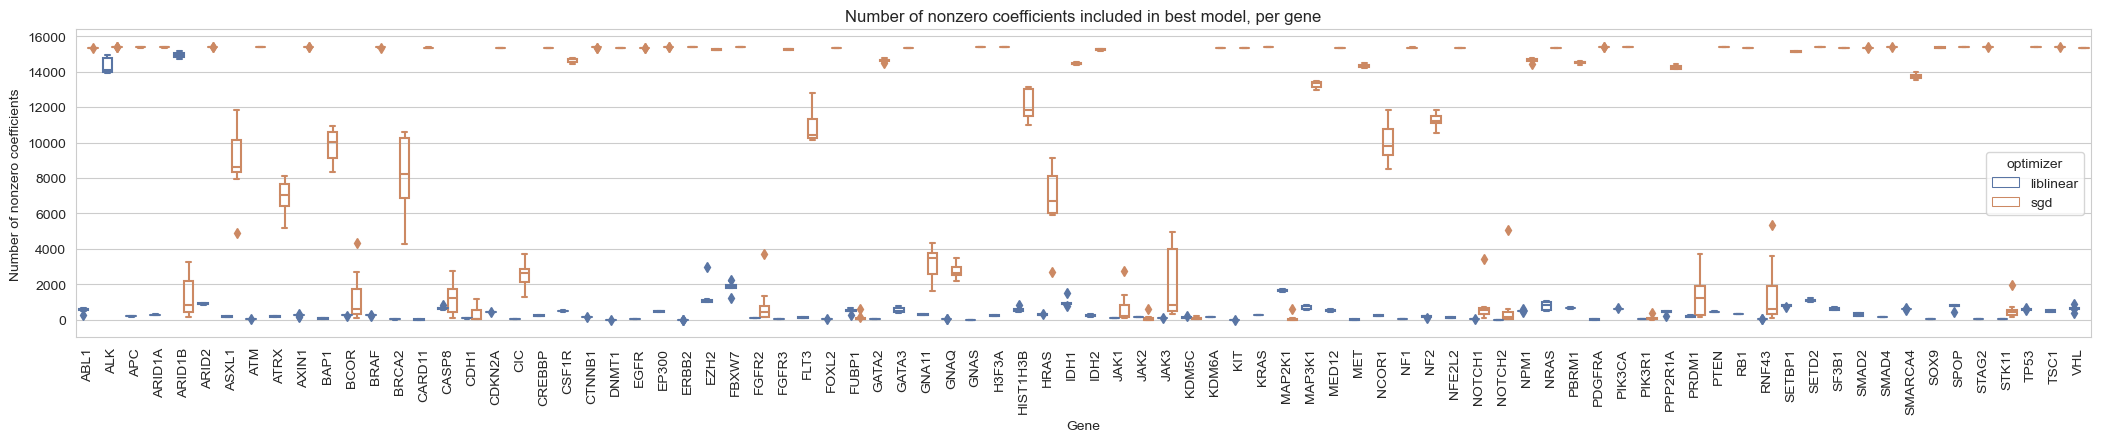

In [17]:
import matplotlib.patches
sns.set({'figure.figsize': (26, 4)})
sns.set_style('whitegrid')

sns.boxplot(data=coefs_perf_df.sort_values(by='gene'),
            x='gene', y='nz_coefs', hue='optimizer')
plt.title('Number of nonzero coefficients included in best model, per gene')
plt.xlabel('Gene')
plt.xticks(rotation=90)
plt.ylabel('Number of nonzero coefficients')
plt.ylim(-1000, coefs_perf_df.nz_coefs.max()+1000)

# color the boxplot lines/edges rather than the box fill
# this makes it easier to discern colors at the extremes; i.e. very many or few nonzero coefs
# https://stackoverflow.com/a/72333641
def color_boxes(ax):
    box_patches = [patch for patch in ax.patches if type(patch) == matplotlib.patches.PathPatch]
    num_patches = len(box_patches)
    lines_per_boxplot = len(ax.lines) // num_patches
    for i, patch in enumerate(box_patches):
        # set the linecolor on the patch to the facecolor, and set the facecolor to None
        col = patch.get_facecolor()
        patch.set_edgecolor(col)
        patch.set_facecolor('None')

        # each box has associated Line2D objects (to make the whiskers, fliers, etc.)
        # loop over them here, and use the same color as above
        for line in ax.lines[i * lines_per_boxplot: (i + 1) * lines_per_boxplot]:
            line.set_color(col)
            line.set_mfc(col)  # facecolor of fliers
            line.set_mec(col)  # edgecolor of fliers
            
    # also fix the legend to color the edges rather than fill
    for legpatch in ax.legend_.get_patches():
        col = legpatch.get_facecolor()
        legpatch.set_edgecolor(col)
        legpatch.set_facecolor('None')
            
color_boxes(plt.gca())